# Port of columnsfmri to python including jupyter demo

Skip the next cell. It contains the model implementation and will eventually move to external python files.

In [235]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def meanpower(s):
    return np.mean(np.abs(s**2))

class sim:
    def __init__(self,N,L):
        self.N = N
        self.L = L
        self.dx = L/self.N
        self.dk = 1/self.L
        self.Fs = 1/self.dx
        
        self.x = np.fft.fftshift(
            np.concatenate(
                (np.arange(0,self.N/2),np.arange(-self.N/2,0))) * self.dx)
        self.k = np.fft.fftshift(
            np.concatenate(
                (np.arange(0,self.N/2),np.arange(-self.N/2,0))) * self.dk)
        self.x1, self.x2 = np.meshgrid(self.x, self.x)
        self.k1, self.k2 = np.meshgrid(self.k, self.k)
        
    def gwnoise(self):
        return np.random.randn(self.N,self.N)
    
    def ft2(self,y):
        return (self.L**2/self.N**2)*np.fft.fftshift(
            np.fft.fft2(np.fft.ifftshift(y)))
    
    def ift2(self,fy):
        return (self.N**2 * self.dk**2)*np.fft.fftshift(
            np.fft.ifft2(np.fft.ifftshift(fy)))
    
    def columnPattern(self,rho,deltaRelative,gwnoise):
        fwhmfactor = 2*np.sqrt(2*np.log(2))
        r = np.sqrt(self.k1**2+self.k2**2)
        if deltaRelative==0:
            FORIENTNotNormalized = np.double(abs(r - rho)<self.dk/2)
        else:
            FORIENTNotNormalized = \
            norm.pdf(r,loc= rho,scale=(rho*deltaRelative)/fwhmfactor) + \
            norm.pdf(r,loc=-rho,scale=(rho*deltaRelative)/fwhmfactor)
        C = (np.sqrt(meanpower(FORIENTNotNormalized)))*np.sqrt(np.pi/8)
        FORIENT = FORIENTNotNormalized/C
        noiseF = self.ft2(gwnoise)
        neuronal = self.ift2(FORIENT*noiseF)
        return neuronal
    
    def bold(self,fwhm,beta,y):
        if fwhm==0:
            by = beta * y
            psf = None
            MTF = np.ones(np.size(y))
        else:
            fwhmfactor = 2*np.sqrt(2*np.log(2))
            psf = beta * \
            norm.pdf(self.x1,loc=0,scale=fwhm/fwhmfactor) * \
            norm.pdf(self.x2,loc=0,scale=fwhm/fwhmfactor)
            MTF = beta * np.exp(-(self.k1**2+self.k2**2) * 
                                2*(fwhm/fwhmfactor)**2*np.pi**2);
            by = self.ift2(MTF*self.ft2(y))
        return by,psf,MTF
    
    def mri(self,w,y):
        nSamplesHalf = self.L/(2*w)
        if nSamplesHalf % 1 == 0:
            nSamplesHalf = int(nSamplesHalf)
            yk = self.ft2(y)
            centerIdx = int(self.N/2)
            downSampledY = yk[centerIdx-nSamplesHalf:centerIdx+nSamplesHalf,
                              centerIdx-nSamplesHalf:centerIdx+nSamplesHalf]
            my = abs(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(downSampledY))))/w**2
        else:
            my = None
        return my
        
    def plotPattern(self,y):
        fig, ax = plt.subplots()
        im = ax.imshow(np.real(y),
                       extent=[min(self.x),max(self.x),min(self.x),max(self.x)],
                       interpolation='bilinear')
        fig.colorbar(im, ax=ax)
        plt.show()
    
    def plotVoxels(self,y):
        fig, ax = plt.subplots()
        im = ax.imshow(np.real(y),
                       extent=[min(self.x),max(self.x),min(self.x),max(self.x)],
                       interpolation='none')
        fig.colorbar(im, ax=ax)
        plt.show()
        

Inititialize simulation using a 512 x 512 grid on an area of 24 x 24 mm. 

In [236]:
N = 512; L = 24
s = sim(Nsim,L)

Simulate a column pattern by filtering Gaussian white noise. Rho is the main pattern frequency, delta specifies the amount of irregularity.

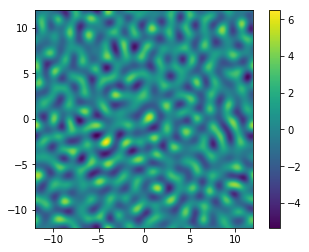

In [237]:
gwn = s.gwnoise()
rho,deltaRelative = 0.5,0.5
columnPattern = s.columnPattern(rho,deltaRelative,gwn)
s.plotPattern(columnPattern)

Simulate a spatial BOLD response with a FWHM of 2 mm, and an average response amplitude of 5%.

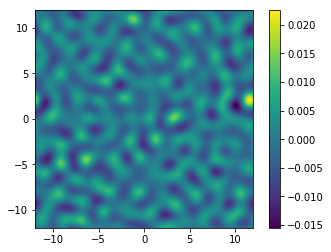

In [238]:
fwhm = 2
beta = 0.05
boldPattern,_,_ = s.bold(fwhm,beta,columnPattern)
s.plotPattern(boldPattern)

Simulate MRI sampling using a voxel width of 3 mm. (We first add the relative response pattern to a constant background of 1).

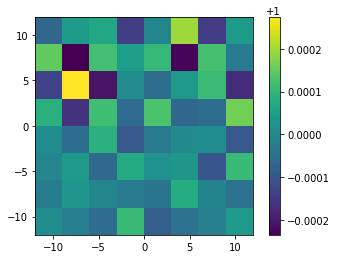

In [240]:
w = 3
mriPattern = s.mri(w,1+b)
s.plotVoxels(mriPattern)

The amount of functional contrast can be quantified as the standard deviation of the imaged responses (contrast range).

In [252]:
c = np.std(mriPattern)
print(str(100*c)+"%")

0.010073100696821737%
